# Ring Cavity Optomechanics with QuantumCumulants

### dynamics of two nano-particles in tweezers held in a ring cavity 

$ H =−ℏΔ\ (a'a + b'b) + ℏG\ a'a * (cos(kz_1) + cos(kz_2)) + ℏG\ b'b * ( sin(kz_1) + sin(kz_2 )) +  (\eta(z_1) + \eta(z_2))  (a+a') ... $ <br>
- sine and cosine mode basis is used for cavity fields
- derivation of linearized form around general position $(z_1, z_2) $ using **Symbolics.jl** <br> 
- all parameters are given in frequency units <br>
- we set $\bf{k=1}$ to fix our length unit of $\lambda=2\pi$

$ a,b ... cavity\ modes , c,d... mechanical\ modes, \eta ... tweezer\ power $  <br>
$ \Delta ... cavity\ detuning, \ \kappa ... cavity\ decay, \ \gamma,\gamma_u ... mech\ damping/heating\ rate, $ <br>

this example exhibits the use of *Symbolics.jl* to generate complex analytic Hamiltonians 

In [1]:
using QuantumCumulants, OrdinaryDiffEq, SteadyStateDiffEq, ModelingToolkit,  Plots

# Hilbertspace
hc = FockSpace(:cavity);         hm = FockSpace(:motion);        h = hc ⊗ hc ⊗ hm ⊗ hm

ℋ(cavity) ⊗ ℋ(cavity) ⊗ ℋ(motion) ⊗ ℋ(motion)

### lets use Symbolics.jl to create the Hamiltonian in linearized form around z1 to order 2 in displacement

In [2]:
using Symbolics

@variables z dz z1 z2 dz₁ dz₂ α β αs βs;           @parameters η; 
D = Differential(z);

#### define electric field f(z) in term of mode functions and its derivatives at particle position z 

In [3]:
f(z,α,β,η)           = α * cos(z) + β * sin(z) + η
df(z,α,β,αs,βs,η)    = D(f(z,α,β,η) * f(z,αs,βs,η))
df2(z,α,β,αs,βs,η)   = D(df(z,α,β,αs,βs,η))

df2 (generic function with 1 method)

#### atom-field interaction function up to second order in displacement from tweezer minimum 

In [4]:
hh(z,dz) = f(z,α,β,η)*f(z,αs,βs,η) + expand_derivatives(df(z,α,β,αs,βs,η))*dz +
           expand_derivatives(df2(z,α,β,αs,βs,η))*dz^2

hh (generic function with 1 method)

apply symbolic expansion to build Hamiltonian function for the two particles at:  z1 + dz1 & z2 + dz2 <br>
and convert it into a Hamiltonian in operator form 

In [5]:
h1 = simplify(substitute.(hh(z,dz) , (Dict(z => z1, dz => dz₁),))[1]);  Hc1 = eval(build_function(h1,z1,dz₁,α,β,αs,βs,η))
h2 = simplify(substitute.(hh(z,dz) , (Dict(z => z2, dz => dz₂),))[1]);  Hc2 = eval(build_function(h2,z2,dz₂,α,β,αs,βs,η))
h1

((-αs*cos(z1) - βs*sin(z1))*(η + α*cos(z1) + β*sin(z1)) + (-α*cos(z1) - β*sin(z1))*(η + αs*cos(z1) + βs*sin(z1)) + 2(β*cos(z1) - α*sin(z1))*(βs*cos(z1) - αs*sin(z1)))*(dz₁^2) + dz₁*((β*cos(z1) - α*sin(z1))*(η + αs*cos(z1) + βs*sin(z1)) + (βs*cos(z1) - αs*sin(z1))*(η + α*cos(z1) + β*sin(z1))) + (η + α*cos(z1) + β*sin(z1))*(η + αs*cos(z1) + βs*sin(z1))

## Hamiltonian in linearized form
$ \omega_m ... tweezer\ trap\ frequency, \ U ... light\ shift,\ z_0 ... ground state\ size, $
$ V ... opt. tweezer\ pot. depth $

In [6]:
@qnumbers a::Destroy(h,1) b::Destroy(h,2) c::Destroy(h,3) d::Destroy(h,4)               # Operators
@cnumbers Δ κ γ γᵤ ω_m z₀ z₁ z₂ U η                                                     # Parameters 

δz₁ = z₀*(c'+ c);     δz₂  = z₀*(d'+ d);                                                # particle displaccement operators 

#### build full two-particle Hamilton operator

In [7]:
H0 = -Δ * ( a'a + b'b ) + ω_m*(c'c + d'd) ;                                  # free Hamiltonian
H1 =  Hc1(z₁,δz₁,a,b,a',b',η) ; H2 =  Hc2(z₂,δz₂,a,b,a',b',η) ;              # interaction Hamiltonian

J = [a, b, c, c', d, d']; rates = [κ, κ, γ, γᵤ, γ, γᵤ]  ;           # Jump operators & mechanical decay / heating rate, γ / γᵤ

H = H0 - U*(H1 + H2);  Hs = simplify(H) ;

#### derive the mean field equation for sin-mode amplitude as test case

In [8]:
eq_a = meanfield([a'],Hs,J;rates=rates,order=1)                # (equation for field amplitude truncated at first order)

∂ₜ(⟨a′⟩) = (0 - 1im)*Δ*⟨a′⟩ + (0//1 - 1//2*im)*U*(sin(2z₁) + sin(2z₂))*⟨b′⟩ + (0 + 1im)*U*η*(-cos(z₁) - cos(z₂)) + U*z₀*((0 + 1im)*⟨a′⟩*⟨c′⟩ + (0 + 1im)*⟨a′⟩*⟨c⟩)*sin(2z₁) + (0 - 1im)*U*(cos(z₁)^2)*⟨a′⟩ + U*(z₀^2)*((0 + 2im)*⟨a′⟩ + (0 + 2im)*(⟨c′⟩^2)*⟨a′⟩)*(cos(z₁)^2) + U*z₀*((0 + 1im)*⟨c′⟩*⟨b′⟩ + (0 + 1im)*⟨b′⟩*⟨c⟩)*(sin(z₁)^2) + U*(z₀^2)*((0 - 2im)*⟨a′⟩ + (0 - 2im)*(⟨c′⟩^2)*⟨a′⟩)*(sin(z₁)^2) + U*(z₀^2)*((0//1 + 2//1*im)*sin(2z₁) + (0//1 + 2//1*im)*sin(2z₂))*⟨b′⟩ + U*(z₀^2)*((0//1 + 2//1*im)*(⟨c′⟩^2)*⟨b′⟩ + (0//1 + 2//1*im)*(⟨c⟩^2)*⟨b′⟩)*sin(2z₁) + (0 - 1im)*U*(cos(z₂)^2)*⟨a′⟩ + U*(z₀^2)*((0//1 + 2//1*im)*(⟨d′⟩^2)*⟨b′⟩ + (0//1 + 2//1*im)*(⟨d⟩^2)*⟨b′⟩)*sin(2z₂) + U*z₀*((0 - 1im)*⟨c′⟩*⟨b′⟩ + (0 - 1im)*⟨b′⟩*⟨c⟩)*(cos(z₁)^2) + U*z₀*((0 - 1im)*⟨b′⟩*⟨d′⟩ + (0 - 1im)*⟨b′⟩*⟨d⟩)*(cos(z₂)^2) + U*z₀*((0 + 1im)*⟨b′⟩*⟨d′⟩ + (0 + 1im)*⟨b′⟩*⟨d⟩)*(sin(z₂)^2) + U*(z₀^2)*((0 + 2im)*(⟨d′⟩^2)*⟨a′⟩ + (0 + 2im)*(⟨d⟩^2)*⟨a′⟩)*(cos(z₂)^2) + U*z₀*((0 + 1im)*⟨a′⟩*⟨d′⟩ + (0 + 1im)*⟨a′⟩*⟨d⟩)*sin(2z₂) + U*(z₀^2)*

###  closed system of coupled equations for phonon numbers of particle 1 and 2 to second cumulant order

In [9]:
ops = [c'c,d'd,a'a,b'b,a,b,c,d];                                 # phonon numbers of particles 
eqs = meanfield(ops,Hs,J;rates=rates,order=2)  ;  # (equtions truncated at 2-ond order)

eqs_full = complete(eqs,order=2);                  # create closed set of equations
eqs_full.states

24-element Vector{Term{QuantumCumulants.AvgSym, Nothing}}:
 ⟨c′*c⟩
 ⟨d′*d⟩
 ⟨a′*a⟩
 ⟨b′*b⟩
 ⟨a⟩
 ⟨b⟩
 ⟨c⟩
 ⟨d⟩
 ⟨a′*b⟩
 ⟨b*c′⟩
 ⟨a*c′⟩
 ⟨a′*c′⟩
 ⟨b′*c′⟩
 ⟨c*c⟩
 ⟨d*d⟩
 ⟨a*d′⟩
 ⟨b*d⟩
 ⟨a′*d′⟩
 ⟨b′*d⟩
 ⟨b*b⟩
 ⟨a*b⟩
 ⟨c′*d′⟩
 ⟨c′*d⟩
 ⟨a*a⟩

Note that printing the whole set of 24 equations needed to close the set is rather lengthy and supressed here 

### Create ODE-system for numerical evaluation  

In [10]:
@named sys = ODESystem(eqs_full);  sys.ps

Sym{Parameter, Base.ImmutableDict{DataType, Any}}[γᵤ, z₀, η, γ, U, z₁, z₂, κ, Δ, ω_m][1:10]

# Numerical examples

###  time evolution of phonon numbers for zero initial cavity photons and two initial excitation values

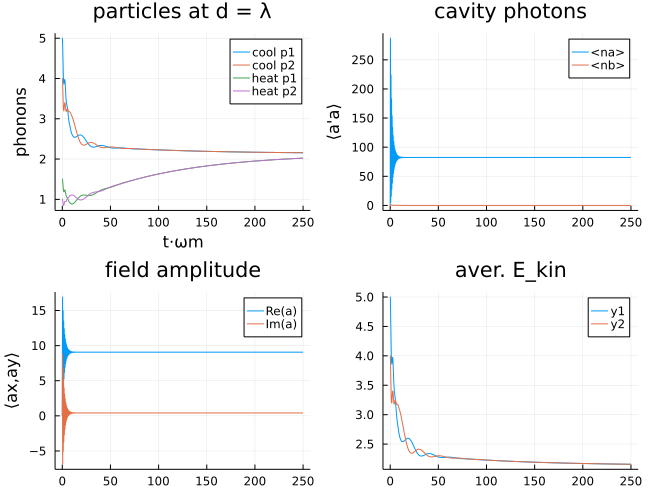

In [11]:
u0 = zeros(ComplexF64, length(eqs_full));  

p0 = (Δ=>-12,  z₀ =>1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m =>10, U =>5.e-1, z₁ =>0, z₂ =>0, η =>100  ) # parameters

tf =250; 
u0[1] = 5;    u0[2] = 4;       prob =  ODEProblem(sys,u0,(0.0,tf),p0);     sol = solve(prob,RK4()) ; 
u0[1] = 1.5;  u0[2] = 1;       prob1 = ODEProblem(sys,u0,(0.0,tf),p0);    sol1 = solve(prob1,RK4()); 

# Plot results
t = real.(sol.t)  ;  nc = real.(sol[c'c]);  nd = real.(sol[d'd]); x1t = z₀*real.(sol[c]) ; x2t = z₀*real.(sol[d]); 
axt = real.(sol[a]) ;  ayt = imag.(sol[a]); na = real.(sol[a'a]); nb = real.(sol[b'b]);

t1 = real.(sol1.t)  ;  nc1 = real.(sol1[c'c]); nd1 = real.(sol1[d'd]);  

p1 = plot(t, nc, xlabel="t⋅ωm", ylabel="phonons",label="cool p1"); plot!(t, nd, ylabel="phonons",label="cool p2", title="particles at d = λ");
plot!(p1,t1, nc1, label="heat p1"); plot!(p1,t1, nd1, label="heat p2");
p2 = plot(t, na, ylabel="⟨a'a⟩", label="<na>"); plot!(p2,t,nb, label="<nb>",title="cavity photons")
p3 = plot(t, axt,label="Re(a)");plot!(t,ayt,label="Im(a)",ylabel="⟨ax,ay⟩",title="field amplitude"); 
p4 = plot(t,nc - abs2.(x1t./z₀)); plot!(t,nd - abs2.(x2t./z₀),title="aver. E_kin")

plot(p1,p2,p3,p4, layout=(2,2), size=(650,500))

*Stationary phonon numbers relax slowly to equal values (translation invariance) while field modes relax much faster * 

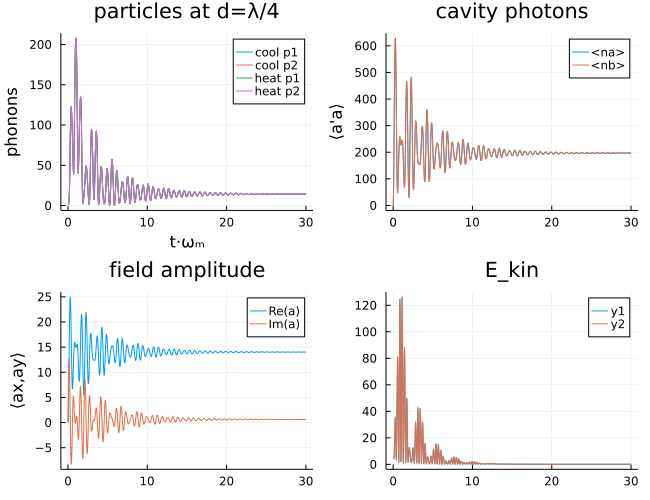

In [12]:
p0 = ( Δ=>-12,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U =>5.e-1, z₁ => 0, z₂ => π/2, η => 300  ) ;    # System parameters
u0 = zeros(ComplexF64, length(eqs_full)) 

tf=30; 
u0[1] = 5;  u0[2] = 4;       prob =  ODEProblem(sys,u0,(0.0,tf),p0);     sol = solve(prob,RK4()) ; 
u0[1] = 2.5;  u0[2] = 1;       prob1 = ODEProblem(sys,u0,(0.0,tf),p0);    sol1 = solve(prob1,RK4()); 

# Plot results
t = real.(sol.t)  ;  nc = real.(sol[c'c]);  nd = real.(sol[d'd]); x1t = z₀*real.(sol[c]) ; x2t = z₀*real.(sol[d]); 
axt = real.(sol[a]) ;  ayt = imag.(sol[a]); na = real.(sol[a'a]); nb = real.(sol[b'b]);

t1 = real.(sol1.t)  ;  nc1 = real.(sol1[c'c]); nd1 = real.(sol1[d'd]);  

p1 = plot(t, nc,xlabel="t⋅ωₘ", ylabel="phonons",label="cool p1"); plot!(t, nd, ylabel="phonons",label="cool p2", title="particles at d=λ/4");
plot!(p1,t1, nc1, label="heat p1"); plot!(p1,t1, nd1, label="heat p2");
p2 = plot(t, na,  ylabel="⟨a'a⟩", label="<na>"); plot!(p2,t,nb, label="<nb>",title="cavity photons")
p3 = plot(t, axt,label="Re(a)");plot!(t,ayt,label="Im(a)",ylabel="⟨ax,ay⟩",title="field amplitude"); 
p4 = plot(t,nc - abs2.(x1t./z₀)); plot!(t,nd - abs2.(x2t./z₀),title="E_kin")

plot(p1,p2,p3,p4, layout=(2,2), size=(650,500))

*particles experience average repulsive/attractive force and are shifted from origin, kinetic energy. however, stays low* 

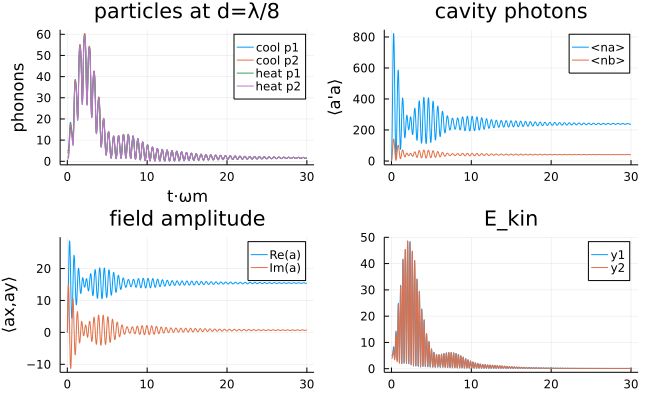

In [13]:
p0 = ( Δ=>-12,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U =>5.e-1, z₁ => 0, z₂ => π/4, η => 200  ) ;    # System parameters
u0 = zeros(ComplexF64, length(eqs_full)) 

tf=30; 
u0[1] = 5;  u0[2] = 4;       prob =  ODEProblem(sys,u0,(0.0,tf),p0);     sol = solve(prob,RK4()) ; 
u0[1] = 2;  u0[2] = 1;       prob1 = ODEProblem(sys,u0,(0.0,tf),p0);    sol1 = solve(prob1,RK4()); 

# Plot results
t = real.(sol.t)  ;  nc = real.(sol[c'c]);  nd = real.(sol[d'd]); x1t = z₀*real.(sol[c]) ; x2t = z₀*real.(sol[d]); 
axt = real.(sol[a]) ;  ayt = imag.(sol[a]); na = real.(sol[a'a]); nb = real.(sol[b'b]);

t1 = real.(sol1.t)  ;  nc1 = real.(sol1[c'c]); nd1 = real.(sol1[d'd]);  

p1 = plot(t, nc,xlabel="t⋅ωm", ylabel="phonons",label="cool p1");
plot!(t, nd, ylabel="phonons",label="cool p2", title="particles at d=λ/8");
plot!(p1,t1, nc1, label="heat p1"); plot!(p1,t1, nd1, label="heat p2");
p2 = plot(t, na, ylabel="⟨a'a⟩", label="<na>"); plot!(p2,t,nb, label="<nb>",title="cavity photons")
p3 = plot(t, axt,label="Re(a)");plot!(t,ayt,label="Im(a)",ylabel="⟨ax,ay⟩",title="field amplitude"); 
p4 = plot(t,nc - abs2.(x1t./z₀)); plot!(t,nd - abs2.(x2t./z₀),title="E_kin")

plot(p1,p2,p3,p4, layout=(2,2), size=(650,400))

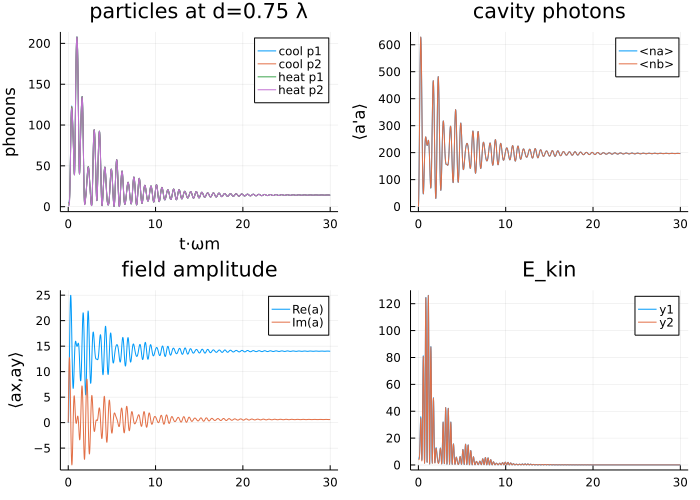

In [14]:
p0 = ( Δ=>-12,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U =>5.e-1, z₁ => 0, z₂ => 3*π/2, η => 300  ) ;    # System parameters
u0 = zeros(ComplexF64, length(eqs_full)) 

tf=30; 
u0[1] = 5;  u0[2] = 4;       prob =  ODEProblem(sys,u0,(0.0,tf),p0);     sol = solve(prob,RK4()) ; 
u0[1] = 2;  u0[2] = 1;       prob1 = ODEProblem(sys,u0,(0.0,tf),p0);    sol1 = solve(prob1,RK4()); 

# Plot results
t = real.(sol.t)  ;  nc = real.(sol[c'c]);  nd = real.(sol[d'd]); x1t = z₀*real.(sol[c]) ; x2t = z₀*real.(sol[d]); 
axt = real.(sol[a]) ;  ayt = imag.(sol[a]); na = real.(sol[a'a]); nb = real.(sol[b'b]);

t1 = real.(sol1.t)  ;  nc1 = real.(sol1[c'c]); nd1 = real.(sol1[d'd]);  

p1 = plot(t, nc,xlabel="t⋅ωm", ylabel="phonons",label="cool p1");
plot!(t, nd, ylabel="phonons",label="cool p2", title="particles at d=0.75 λ");
plot!(p1,t1, nc1, label="heat p1"); plot!(p1,t1, nd1, label="heat p2");
p2 = plot(t, na, ylabel="⟨a'a⟩", label="<na>"); plot!(p2,t,nb, label="<nb>",title="cavity photons")
p3 = plot(t, axt,label="Re(a)");plot!(t,ayt,label="Im(a)",ylabel="⟨ax,ay⟩",title="field amplitude"); 
p4 = plot(t,nc - abs2.(x1t./z₀)); plot!(t,nd - abs2.(x2t./z₀),title="E_kin")

plot(p1,p2,p3,p4, layout=(2,2), size=(700,500))

### use higher tweezer power 

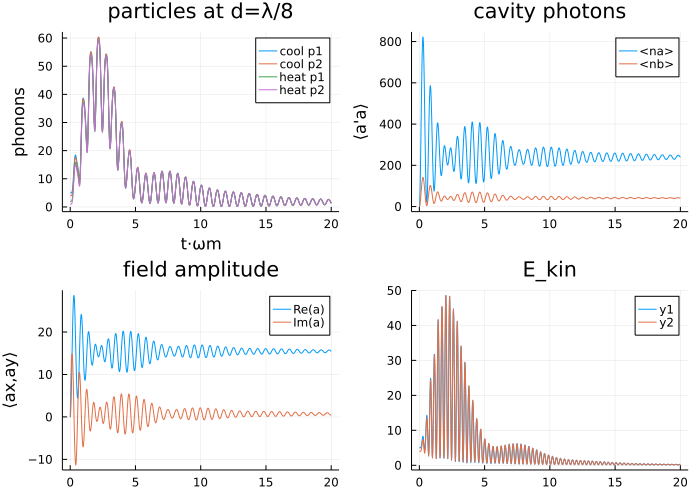

In [15]:
p0 = ( Δ=>-12,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U =>5.e-1, z₁ => 0, z₂ => π/4, η => 200  ) ;    # System parameters
u0 = zeros(ComplexF64, length(eqs_full)) 

tf=20; 
u0[1] = 5;  u0[2] = 4;       prob =  ODEProblem(sys,u0,(0.0,tf),p0);     sol = solve(prob,RK4()) ; 
u0[1] = 2;  u0[2] = 1;       prob1 = ODEProblem(sys,u0,(0.0,tf),p0);    sol1 = solve(prob1,RK4()); 

# Plot results
t = real.(sol.t)  ;  nc = real.(sol[c'c]);  nd = real.(sol[d'd]); x1t = z₀*real.(sol[c]) ; x2t = z₀*real.(sol[d]); 
axt = real.(sol[a]) ;  ayt = imag.(sol[a]); na = real.(sol[a'a]); nb = real.(sol[b'b]);

t1 = real.(sol1.t)  ;  nc1 = real.(sol1[c'c]); nd1 = real.(sol1[d'd]);  

p1 = plot(t, nc,xlabel="t⋅ωm", ylabel="phonons",label="cool p1");
plot!(t, nd, ylabel="phonons",label="cool p2", title="particles at d=λ/8");
plot!(p1,t1, nc1, label="heat p1"); plot!(p1,t1, nd1, label="heat p2");
p2 = plot(t, na, ylabel="⟨a'a⟩", label="<na>"); plot!(p2,t,nb, label="<nb>",title="cavity photons")
p3 = plot(t, axt,label="Re(a)");plot!(t,ayt,label="Im(a)",ylabel="⟨ax,ay⟩",title="field amplitude"); 
p4 = plot(t,nc - abs2.(x1t./z₀)); plot!(t,nd - abs2.(x2t./z₀),title="E_kin")

plot(p1,p2,p3,p4, layout=(2,2), size=(700,500))

*more power creates bigger average displacement = steady state phonons but faster cooling and lower final kinetic energy *

## Calculation of steady state phonons for different relative positions and detunings

#### steady state is obtained  via time evolution
*here use rather low solution accuracy to save computing time - maybe steady state solver could be improved * 

### compare three different powers

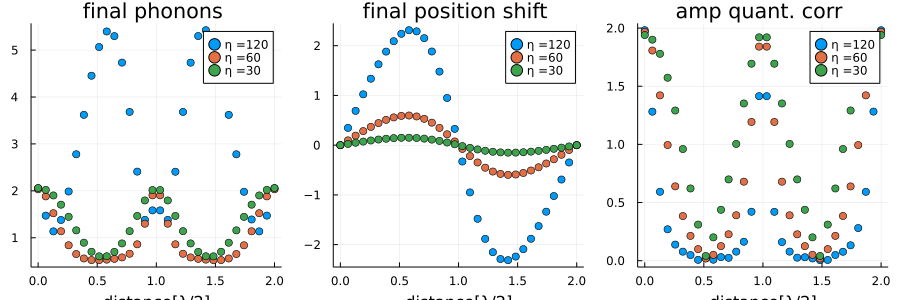

In [16]:
nz=32; zv = LinRange(0,2π,nz); 
nca=zeros(nz); nda=zeros(nz); ncb=zeros(nz); ndb=zeros(nz); ; ncc=zeros(nz); ndc=zeros(nz);
x1a=zeros(nz); x1b=zeros(nz); x1c=zeros(nz); e1a=zeros(nz); e1b=zeros(nz); e1c=zeros(nz);

par(zd) = ( Δ=>-10,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zd, η => 120  ) ;

u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 5; u0[2] = 5; 

for iz=1:nz
    
   probz = ODEProblem(sys,u0,(0.0,1000),par(zv[iz]));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-3), maxiters=5.0e4,verbose=false)
    
   nca[iz] = real.(sol_z.u[1]);  nda[iz] = real.(sol_z.u[2]); x1a[iz] = real.(sol_z.u[7]);
   e1a[iz] =  abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8]) 
   u0 = sol_z.u 
end

par(zd) = ( Δ=>-10,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zd, η => 60  ) ;

u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 5; u0[2] = 5; 

for iz=1:nz
    
   probz = ODEProblem(sys,u0,(0.0,1000),par(zv[iz]));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-3), maxiters=5.0e4,verbose=false)
    
   ncb[iz] = real.(sol_z.u[1]);  ndb[iz] = real.(sol_z.u[2]); x1b[iz] = real.(sol_z.u[7]);
   e1b[iz] =  abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8])  
   u0 = sol_z.u 
end

par(zd) = ( Δ=>-10,  z₀ => 1.e-2,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zd, η => 30  ) ;

u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 5; u0[2] = 5; 

for iz=1:nz
    
   probz = ODEProblem(sys,u0,(0.0,1000),par(zv[iz]));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-3), maxiters=5.0e4,verbose=false)
    
   ncc[iz] = real.(sol_z.u[1]);  ndc[iz] = real.(sol_z.u[2]); x1c[iz] = real.(sol_z.u[7])
   e1c[iz] =  abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8])  
   u0= sol_z.u 
end

p1=scatter(zv/π,nda,label="η =120",title="final phonons ",xlabel="distance[λ/2]")
scatter!(p1,zv/π,ndb,label="η =60");scatter!(p1,zv/π,ndc,label="η =30")
p2=scatter(zv/π,x1a,label="η =120",title="final position shift ",xlabel="distance[λ/2]")
scatter!(p2,zv/π,x1b,label="η =60");scatter!(p2,zv/π,x1c,label="η =30")
p3=scatter(zv/π,e1a,label="η =120",title="amp quant. corr ",xlabel="distance[λ/2]")
scatter!(p3,zv/π,e1b,label="η =60");scatter!(p3,zv/π,e1c,label="η =30")

plot(p1,p2,p3,layout=(1,3))
savefig("phonons_shift_corr.pdf")
plot!(size=(900,300))

*mean interparticle force depends on distance - equilibrium distance shift can be seen on starionary phonon numbers*

##  Detuning  and distance dependence of stationary phonon and photon numbers

#### calculation of quantum correlation of oscillator amplitudes : ($ <c' d> - <c'><d> $) indicates entanglement 

In [17]:
nz=12; zv = LinRange(0,π,nz); na=zeros(nz); nb=zeros(nz);  nc=zeros(nz); nd=zeros(nz);
nx1=zeros(nz); nx2=zeros(nz); vx1=zeros(nz); ent12=zeros(nz);

p1=scatter(); p2=scatter(); p3=scatter(); p4=scatter(); p5=scatter(); p6=scatter(); p7=scatter(); p8=scatter();
δv = [-15,-12,-10,-8,-5]; z0 = 1.e-2;

for id=1:5

par(zd) = ( Δ=>δv[id],  z₀ => z0,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zd, η => 100  ) ;
u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 2; u0[2] = 2; 

for iz=1:nz
    
   probz = ODEProblem(sys,u0,(0.0,10),par(zv[iz]));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-5), maxiters=3.0e4,verbose=false)
    
   nc[iz] = real.(sol_z.u[1]);  nd[iz] = real.(sol_z.u[2]); 
   na[iz] = real.(sol_z.u[13]);  nb[iz] = real.(sol_z.u[14]); 
   nx1[iz] = real.(sol_z.u[7]);  nx2[iz] = real.(sol_z.u[8]); 
   vx1[iz] = nc[iz] - abs2.(sol_z.u[7]); 
   ent12[iz] = abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8]);         
        
   u0 = sol_z.u      
end

scatter!(p1,zv/π,nc,label="δ = $(δv[id])",   title="final phonons left");
scatter!(p2,zv/π,nd,xlabel="distance[λ/2]",  title="final phonons right",legend=false) 
    scatter!(p3,zv/π,na,label="δ = $(δv[id])",   title="final photons cos",xlabel="distance[λ/2]",legend=false); 
scatter!(p4,zv/π,nb,  title="final photons sin",legend=false)
scatter!(p5,zv/π,nx1, ylabel="δx1/z₀" , title="displacement 1",legend=false); 
scatter!(p6,zv/π,nx2,xlabel="distance[λ/2]",ylabel="δx2/z₀" , title="displacement 2",legend=false)
scatter!(p7,zv/π,vx1,xlabel="distance[λ/2]",ylabel="vx1" , title="delta_x",legend=false)
scatter!(p8,zv/π,ent12,xlabel="distance[λ/2]",ylabel="<c,d>" , title="entangle",legend=false)
end

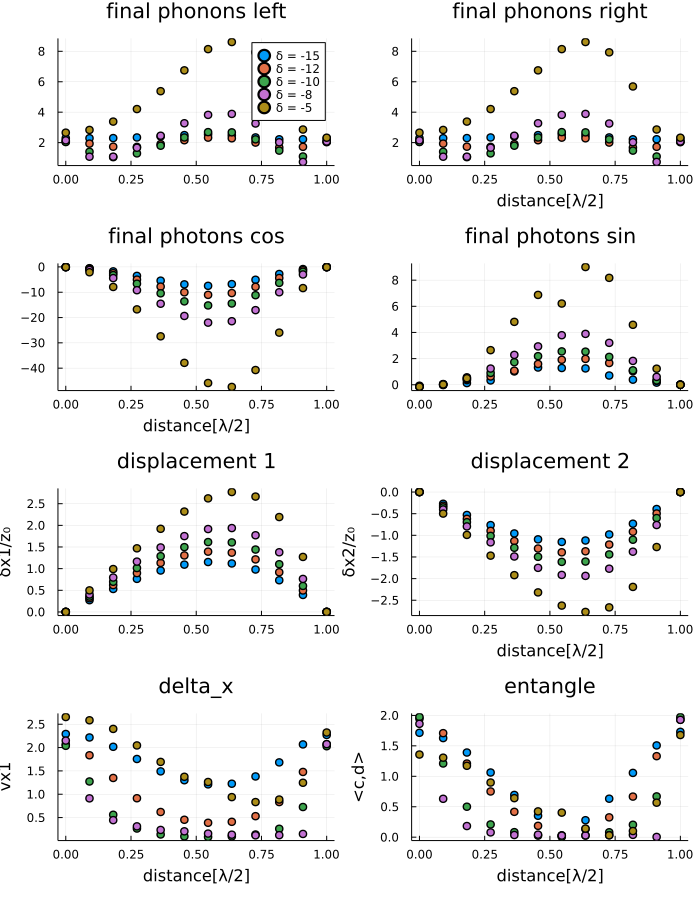

In [18]:
plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2),size=(700,900))

## detuning and distance scan of steady state
(can be very slow for a larger number of points)

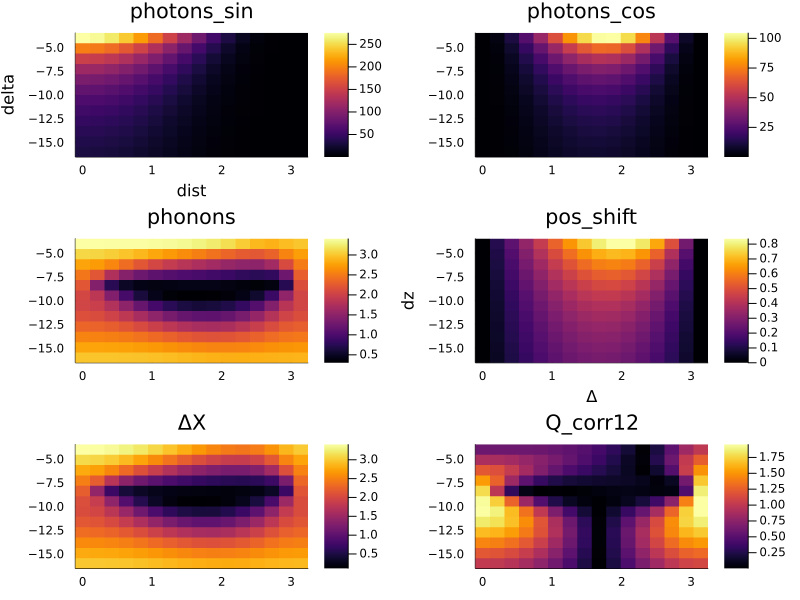

In [26]:
nz=16; zv = LinRange(0,π,nz);  ndd=12; δv = LinRange(-16,-4,ndd);
na=zeros(ndd,nz); nb=zeros(ndd,nz);  nc=zeros(ndd,nz); nd=zeros(ndd,nz);
nx1=zeros(ndd,nz); nx2=zeros(ndd,nz); vx1=zeros(ndd,nz); qcorr12=zeros(ndd,nz);

z0 = 1.e-2;    u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 2; u0[2] = 2; 

par(id,iz) = ( Δ=>δv[id],  z₀ => z0,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zv[iz], η => 50  ) ;

for id = 1:ndd, iz = 1:nz

   probz = ODEProblem(sys,u0,(0.0,10),par(id,iz));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-5), maxiters=3.0e4,verbose=false)
    
   nc[id,iz]  = real.(sol_z.u[1]);  nd[id,iz] = real.(sol_z.u[2]); 
   na[id, iz] = real.(sol_z.u[3]);  nb[id,iz] = real.(sol_z.u[4]); 
   nx1[id,iz] = real.(sol_z.u[7]);  nx2[id,iz] = real.(sol_z.u[8]); 
   vx1[id,iz] = nc[id,iz] - abs2.(sol_z.u[7]); 
   qcorr12[id,iz] = abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8]);         
        
   u0 = sol_z.u      
end

p1=heatmap(zv,δv,na,title="photons_sin",ylabel="delta",xlabel="dist");
p2=heatmap(zv,δv,nb,title="photons_cos");
p3=heatmap(zv,δv,nc,title="phonons");
p4=heatmap(zv,δv,nx1,title="pos_shift",xlabel="Δ",ylabel="dz");
p5=heatmap(zv,δv,vx1,title="ΔX");
p6=heatmap(zv,δv,qcorr12,title="Q_corr12");
plot(p1,p2,p3,p4,p5,p6,layout=(3,2),size=(800,600))
savefig("optmech2p_scan_1.pdf")
plot!()

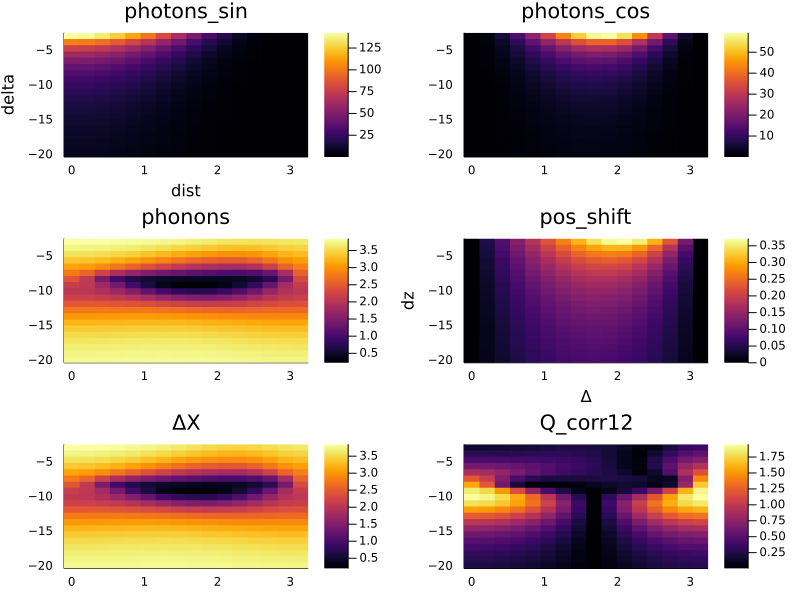

In [25]:
nz=16; zv = LinRange(0,π,nz);  ndd=20; δv = LinRange(-20,-3,ndd);
na=zeros(ndd,nz); nb=zeros(ndd,nz);  nc=zeros(ndd,nz); nd=zeros(ndd,nz);
nx1=zeros(ndd,nz); nx2=zeros(ndd,nz); vx1=zeros(ndd,nz); qcorr12=zeros(ndd,nz);

z0 = 1.e-2;    u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 2; u0[2] = 2; 

par(id,iz) = ( Δ=>δv[id],  z₀ => z0,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zv[iz], η => 30  ) ;

for id = 1:ndd, iz = 1:nz

   probz = ODEProblem(sys,u0,(0.0,10),par(id,iz));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-5), maxiters=3.0e4,verbose=false)
    
   nc[id,iz]  = real.(sol_z.u[1]);  nd[id,iz] = real.(sol_z.u[2]); 
   na[id, iz] = real.(sol_z.u[3]);  nb[id,iz] = real.(sol_z.u[4]); 
   nx1[id,iz] = real.(sol_z.u[7]);  nx2[id,iz] = real.(sol_z.u[8]); 
   vx1[id,iz] = nc[id,iz] - abs2.(sol_z.u[7]); 
   qcorr12[id,iz] = abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8]);         
        
   u0 = sol_z.u      
end

p1=heatmap(zv,δv,na,title="photons_sin",ylabel="delta",xlabel="dist");
p2=heatmap(zv,δv,nb,title="photons_cos");
p3=heatmap(zv,δv,nc,title="phonons");
p4=heatmap(zv,δv,nx1,title="pos_shift",xlabel="Δ",ylabel="dz");
p5=heatmap(zv,δv,vx1,title="ΔX");
p6=heatmap(zv,δv,qcorr12,title="Q_corr12");
plot(p1,p2,p3,p4,p5,p6,layout=(3,2),size=(800,600))
savefig("optmech2p_scan_2.pdf")
plot!()

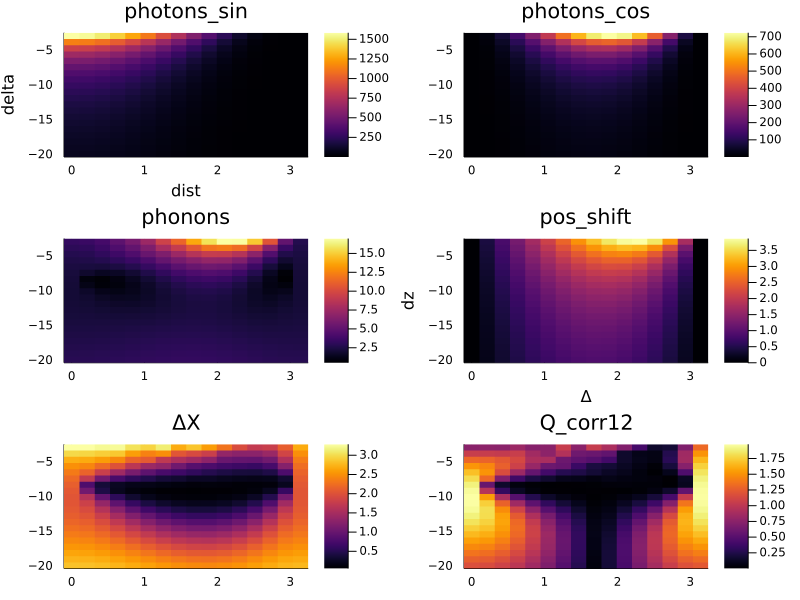

In [23]:
nz=16; zv = LinRange(0,π,nz);  ndd=20; δv = LinRange(-20,-3,ndd);
na=zeros(ndd,nz); nb=zeros(ndd,nz);  nc=zeros(ndd,nz); nd=zeros(ndd,nz);
nx1=zeros(ndd,nz); nx2=zeros(ndd,nz); vx1=zeros(ndd,nz); qcorr12=zeros(ndd,nz);

z0 = 1.e-2;    u0 = zeros(ComplexF64, length(eqs_full)) ; u0[1] = 2; u0[2] = 2; 

par(id,iz) = ( Δ=>δv[id],  z₀ => z0,  κ=>1, γ=>0.05, γᵤ=>0.04, ω_m => 10, U=>-1, z₁ => 0, z₂ => zv[iz], η => 100  ) ;

for id = 1:ndd, iz = 1:nz

   probz = ODEProblem(sys,u0,(0.0,10),par(id,iz));  prob_ss = SteadyStateProblem(probz)
   sol_z = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-5, reltol=1e-5), maxiters=3.0e4,verbose=false)
    
   nc[id,iz]  = real.(sol_z.u[1]);  nd[id,iz] = real.(sol_z.u[2]); 
   na[id, iz] = real.(sol_z.u[3]);  nb[id,iz] = real.(sol_z.u[4]); 
   nx1[id,iz] = real.(sol_z.u[7]);  nx2[id,iz] = real.(sol_z.u[8]); 
   vx1[id,iz] = nc[id,iz] - abs2.(sol_z.u[7]); 
   qcorr12[id,iz] = abs.(sol_z.u[23]-sol_z.u[7]'*sol_z.u[8]);         
        
   u0 = sol_z.u      
end

p1=heatmap(zv,δv,na,title="photons_sin",ylabel="delta",xlabel="dist");
p2=heatmap(zv,δv,nb,title="photons_cos");
p3=heatmap(zv,δv,nc,title="phonons");
p4=heatmap(zv,δv,nx1,title="pos_shift",xlabel="Δ",ylabel="dz");
p5=heatmap(zv,δv,vx1,title="ΔX");
p6=heatmap(zv,δv,qcorr12,title="Q_corr12");
plot(p1,p2,p3,p4,p5,p6,layout=(3,2),size=(800,600))
savefig("optmech2p_scan_3.pdf")
plot!()